### *This file allows to initialize a STG spiking neuron as well as neuromodulating them in a robust way with a controller*

# **Useful packages and functions**

In [10]:
using DifferentialEquations, Plots, Plots.PlotMeasures, LaTeXStrings, Random, Dierckx, DelimitedFiles
using Interpolations
include("STG_kinetics.jl") # Loading of STG kinetics of gating variables
include("STG_models.jl") # Loading of STG model
include("STG_utils.jl") # Loading of some utils functions
include("STG_gs_derivatives.jl") # Loading of X_inf derivatives
include("STG_DIC.jl") # Loading of the DIC and compensation algorithm
include("STG_neuromodulation.jl") # Loading of the neuromodulation cells functions
include("STG_large_simulations.jl"); # Loading of the neuromodulation cells functions

# **Global variables**

In [2]:
# Definition of simulation time (in ms)
const Tfinal = 300000
const tspan  = (0.0, Tfinal)

# Definition of reversal potential values (in mV) and membrane capacitance
const VNa   = 50. # Sodium reversal potential
const VK    = -80. # Potassium reversal potential
const VCa   = 80. # Calcium reversal potential
const VH    = -20. # Reversal potential for the H-current (permeable to both sodium and potassium ions)
const Vleak = -50. # Reversal potential of leak channels
const C     = 1. # Membrane capacitance

# Definition of voltage range for the DICs
const Vmin = -60 
const Vmax = 0
const V    = range(Vmin, stop=Vmax, step=0.01)

# Definition of the number of cells in the random set
const ncells = 200

# Modifying backend GR attributes
gr(guidefontsize=18, legendfontsize=12, margin=5Plots.mm, grid=false)
myApple = RGBA(187/255, 206/255, 131/255, 1)
mySalmon = RGBA(243/255, 124/255, 130/255)
myYellow = RGBA(228/255, 205/255, 121/255, 1)
myBlue = RGBA(131/255, 174/255, 218/255, 1)
myDarkBlue = RGBA(114/255, 119/255, 217/255, 1)
myOrange = RGBA(241/255, 175/255, 113/255, 1)
myPink = RGBA(243/255, 124/255, 130/255, 1)
myPurple = RGBA(169/255, 90/255, 179/255, 1)
myGreen = RGBA(132/255, 195/255, 168/255, 1)
myRed = RGBA(158/255, 3/255, 8/255, 1)
myGray = RGBA(150/255, 150/255, 150/255, 1)
myLightBlue = RGBA(127/255, 154/255, 209/255, 1)
default(fmt = :png)

# Moving average function
moving_average(vs, n, padding) = [sum(vs[i:(i+n-1)])/n for i in 1:padding:(length(vs)-(n-1))];

# **Neuromodulation gCaS and gA overall**

## **Computation of gCaS and gA**

In [3]:
# Fixing random seed
Random.seed!(544)

# Initial firing pattern
guth = 4.
Vth = -50.
(g_all_init, ICs_th_init) = degeneracy_fixDICs_neuromod(ncells, 5., guth, Vth);
# create a spiking set with max variability in gCaS and gA

In [4]:
# Definition of parameters
α = 5e-3 # Rate of transfer between intracellular and membrane
β = 5e-3 # Rate of degradation of intracellular proteins
Kp = 3e-4 # Proprtional gain
Ki = 5e-6 # Integral gain
Kt = β / Ki # Anti-windup gain
gsth_sim(t) = 5 - 13 * pulse(t, Tfinal/2, Tfinal) # Reference
guth_sim(t) = 4.
u_maxCaS = 1e7 # Maximum value of actuator
u_maxH = 1e7

# Definition of homeostatic parameters
tau_g = 100 # Conductance time constant
tau_Na = 600 # Sodium integral action time constants
Ca_tgt(t) = 125. # Calcium target

# Input current definition
Iapp = 0.

tt = 0. : 0.2 : Tfinal

window_size_s = 5
padding_s = 0.2
window_size_ = Int64(round(window_size_s*1000*length(tt)/(Tfinal)))
padding_ = Int64(round(padding_s*1000*length(tt)/(Tfinal)))
tt_moving_average_ = window_size_s/2 : padding_s : Tfinal/1000 - window_size_s/2
tt_moving_average_plot = range(0, Tfinal/1e3, length(tt_moving_average_));

In [5]:
gNa_matrix, gCaT_matrix, gCaS_matrix, gA_matrix, gKCa_matrix, gKd_matrix, gH_matrix, 
gleak_matrix, Ca_ma_matrix = simulate_STG_population_H(g_all_init, Iapp, tau_Na, tau_g, Ca_tgt,
                                                     C, α, β, Kp, Ki, Kt, gsth_sim, guth_sim,
                                                     ICs_th_init, u_maxCaS, u_maxH, tt)

Computing... 100%|███████████████████████████████████████| Time: 3:13:20


([3951.8419160978906 4084.390243673059 … 3076.705237780022 3078.9112254932847; 6206.16483952284 6253.5220199292635 … 3175.4070067849034 3173.9761208563123; … ; 5828.815558986859 5924.801730331086 … 3991.6414800478774 3990.4059574734497; 3647.5523741768225 3786.4145342535558 … 4042.2944473466273 4068.045618090803], [2.9127829553262305 3.0104803120310013 … 2.2677462219979803 2.269372188711045; 8.240498245324952 8.303378747556764 … 4.216281156593615 4.214381237192732; … ; 3.7236085851028164 3.784927206021856 … 2.5499709732352995 2.549181687244202; 1.6468570689115483 1.7095528458236833 … 1.8250817266841055 1.8367082897111389], [7.284855541341288 7.6362904799327875 … 23.084518645614075 23.084422638651176; 15.278731403514088 15.643310780790548 … 24.726008759118724 24.725963546445403; … ; 10.21380821109023 10.731476320263534 … 29.856513778689077 29.8172394864701; 10.02023695641985 10.37843465229671 … 33.09045911271527 33.055067529261194], [239.38396605018818 247.4131192961745 … 186.3723088686

In [6]:
writedlm("./data/gNa_matrix_H.dat", gNa_matrix)
writedlm("./data/gCaT_matrix_H.dat", gCaT_matrix)
writedlm("./data/gCaS_matrix_H.dat", gCaS_matrix)
writedlm("./data/gA_matrix_H.dat", gA_matrix)
writedlm("./data/gKCa_matrix_H.dat", gKCa_matrix)
writedlm("./data/gKd_matrix_H.dat", gKd_matrix)
writedlm("./data/gH_matrix_H.dat", gH_matrix)
writedlm("./data/gleak_matrix_H.dat", gleak_matrix)
writedlm("./data/Ca_ma_matrix_H.dat", Ca_ma_matrix)

In [7]:
gNa_matrix = readdlm("./data/gNa_matrix.dat")
gCaT_matrix = readdlm("./data/gCaT_matrix.dat")
gCaS_matrix = readdlm("./data/gCaS_matrix.dat")
gA_matrix = readdlm("./data/gA_matrix.dat")
gKCa_matrix = readdlm("./data/gKCa_matrix.dat")
gKd_matrix = readdlm("./data/gKd_matrix.dat")
gH_matrix = readdlm("./data/gH_matrix.dat")
gleak_matrix = readdlm("./data/gleak_matrix.dat")
Ca_ma_matrix = readdlm("./data/Ca_ma_matrix.dat");

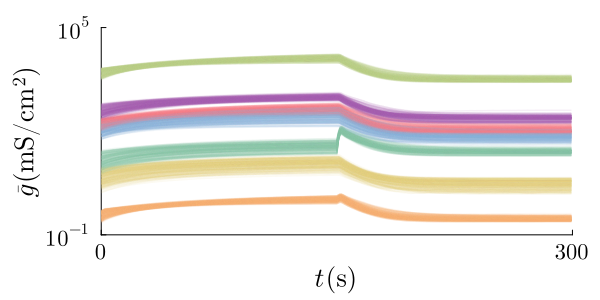

In [7]:
p1 = plot(ylims=(1e-1, 1e5), yticks=([1e-1, 1e5], [L"10^{-1}", L"10^{5}"]), guidefontsize=18,
           xticks=([0, 300], [L"0", L"300"]), tickfontsize=15, size=(600, 300), xlims=(0, 300))

xlabel!(L"t\,\mathrm{(s)}")
ylabel!(L"\bar{g}\,\mathrm{(mS/cm^2)}")

for i = 1 : ncells
    plot!(tt[2:5000:end]./1e3, gNa_matrix[i, :], color=myApple, linewidth=1.5,
          legend=false, alpha=0.1, yaxis=:log)
    plot!(tt[2:5000:end]./1e3, gCaT_matrix[i, :], color=myYellow, linewidth=1.5,
          legend=false, alpha=0.1, yaxis=:log)
    plot!(tt[2:5000:end]./1e3, gA_matrix[i, :], color=myPurple, linewidth=1.5,
          legend=false, alpha=0.1, yaxis=:log)
    plot!(tt[2:5000:end]./1e3, gCaS_matrix[i, :], color=myGreen, linewidth=1.5,
          legend=false, alpha=0.1, yaxis=:log)
    plot!(tt[2:5000:end]./1e3, gKCa_matrix[i, :], color=myBlue, linewidth=1.5,
          legend=false, alpha=0.1, yaxis=:log)
    plot!(tt[2:5000:end]./1e3, gKd_matrix[i, :], color=myPink, linewidth=1.5,
          legend=false, alpha=0.1, yaxis=:log)
    plot!(tt[2:5000:end]./1e3, gH_matrix[i, :], color=myOrange, linewidth=1.5,
          legend=false, alpha=0.1, yaxis=:log)
    plot!(tt[2:5000:end]./1e3, gleak_matrix[i, :], color=myDarkBlue, linewidth=1.5,
          legend=false, alpha=0.1, yaxis=:log)
end

display(p1)
# savefig(p1, "./figures/g_all_H.pdf")

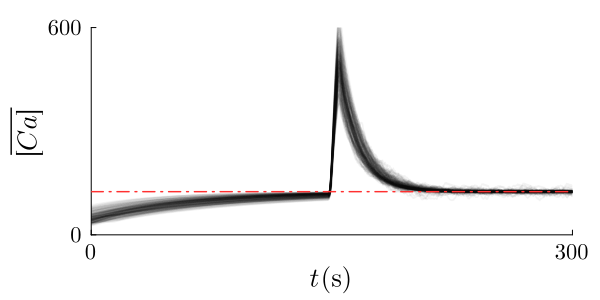

In [8]:
p1b = plot(size=(600, 300), ylims=(0, 600), yticks=([0, 600], [L"0", L"600"]), 
           xlims=(0, 300), guidefontsize=18, xticks=([0, 300], [L"0", L"300"]), tickfontsize=15)

ylabel!(L"\overline{[Ca]}")
xlabel!(L"t\,\mathrm{(s)}")

for i = 1 : ncells
    plot!(tt_moving_average_plot, Ca_ma_matrix[i, :], linewidth=1.5, color=:black, 
          alpha=0.05, legend=false)
end

plot!([0, 300], [125, 125], color=:firebrick1, linestyle=:dashdot, linewidth=1.5)

display(p1b)
# savefig(p1b, "./figures/Ca_ma_H.pdf")

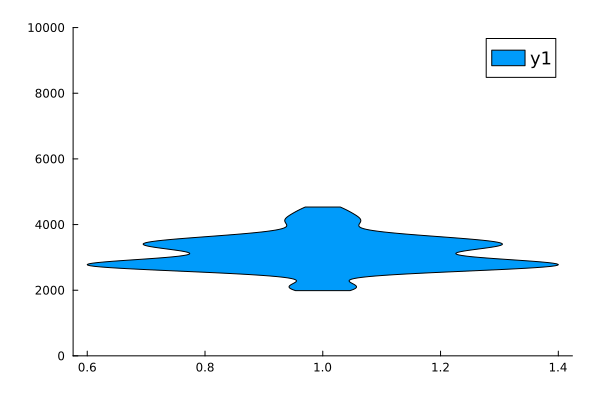

In [24]:
tt_g = tt[2:5000:end]./1e3
i_acute = findall(tt_g .> 180 .&& tt_g .< 181)[1]
burstiness_acute = zeros(ncells)
for i = 1 : ncells
    gNa = gNa_matrix[i, i_acute]
    gCaT = gCaT_matrix[i, i_acute]
    gCaS = gCaS_matrix[i, i_acute]
    gA = gA_matrix[i, i_acute]
    gKCa = gKCa_matrix[i, i_acute]
    gKd = gKd_matrix[i, i_acute]
    gH = gH_matrix[i, i_acute]
    gleak = gleak_matrix[i, i_acute]
    
    p = (Iapp, gNa, gCaT, gCaS, gA, gKCa, gKd, gH, gleak, C)
    # Initial conditions
    V0  = -70.
    Ca0 = 0.5
    x0  = [V0, mNa_inf(V0), hNa_inf(V0), mCaT_inf(V0), hCaT_inf(V0), mCaS_inf(V0), hCaS_inf(V0),
            mA_inf(V0), hA_inf(V0), mKCa_inf(V0, Ca0), mKd_inf(V0), mH_inf(V0), Ca0]
    # Simulation
    prob = ODEProblem(STG_ODE, x0, (0, Tfinal/100), p) # Describing the problem
    sol = solve(prob) # Solving the problem

    tt_short = Tfinal/300 : 0.1 : Tfinal/100;
    x = sol(tt_short)
    V_short = x[1, :]
    burstiness_acute[i], _, _, _ = extract_burstiness(V_short, tt_short)
#     display(plot(tt_short, V_short))
end
violin(burstiness_acute)
ylims!((0, 10000))

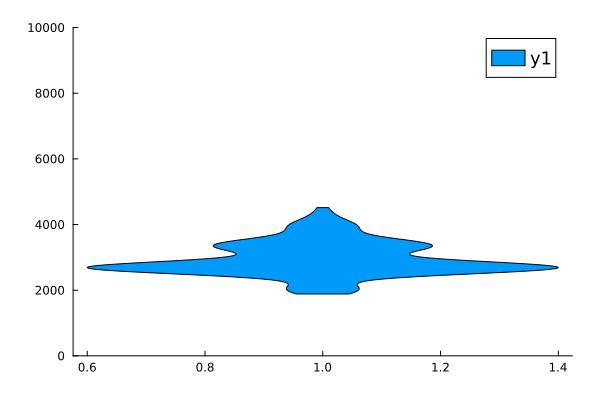

In [22]:
burstiness_end = zeros(ncells)
for i = 1 : ncells
    gNa = gNa_matrix[i, end]
    gCaT = gCaT_matrix[i, end]
    gCaS = gCaS_matrix[i, end]
    gA = gA_matrix[i, end]
    gKCa = gKCa_matrix[i, end]
    gKd = gKd_matrix[i, end]
    gH = gH_matrix[i, end]
    gleak = gleak_matrix[i, end]
    
    p = (Iapp, gNa, gCaT, gCaS, gA, gKCa, gKd, gH, gleak, C)
    # Initial conditions
    V0  = -70.
    Ca0 = 0.5
    x0  = [V0, mNa_inf(V0), hNa_inf(V0), mCaT_inf(V0), hCaT_inf(V0), mCaS_inf(V0), hCaS_inf(V0),
            mA_inf(V0), hA_inf(V0), mKCa_inf(V0, Ca0), mKd_inf(V0), mH_inf(V0), Ca0]
    # Simulation
    prob = ODEProblem(STG_ODE, x0, (0, Tfinal/100), p) # Describing the problem
    sol = solve(prob) # Solving the problem

    tt_short = Tfinal/300 : 0.1 : Tfinal/100;
    x = sol(tt_short)
    V_short = x[1, :]
    burstiness_end[i], _, _, _ = extract_burstiness(V_short, tt_short)
    if isnan(burstiness_end[i])
        burstiness_end[i] = 0
    end
#     display(plot(tt_short, V_short))
end

violin(burstiness_end)
ylims!((0, 10000))

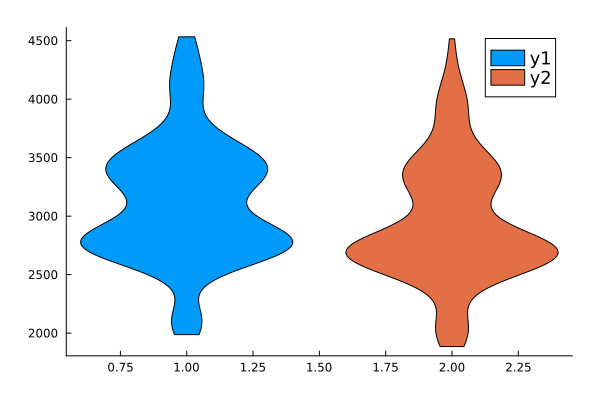

In [25]:
violin([burstiness_acute, burstiness_end])

In [ ]:
write